In [1]:
import os 
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings 
warnings.filterwarnings('ignore')

from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

2025-09-25 19:48:24.832074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758829705.042850      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758829705.106213      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path  = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
Categories = ['benign','malignant','normal']

ultrasound_image = []
mask_image     = defaultdict(list)

for category in Categories:
    folder = os.path.join(base_path,category)
    for file in os.listdir(folder):
        file_path = os.path.join(folder,file)

        if "_mask" in file:
            base_name = file.split("_mask")[0]     # "benign (100)"
            mask_image[base_name].append(file_path)
        else :
            ultrasound_image.append(file_path)

data = []
for img_path in ultrasound_image:
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    masks     = mask_image.get(base_name,[])  # get list of masks (may be empty for normal)

    # Assign labels
    if "benign" in img_path:
        label = "benign"
    elif "malignant" in img_path:
        label = "malignant"
    else :
        label = "normal"

    data.append({
        "image_path": img_path,
        "mask_paths": masks,
        "label": label
    })

df = pd.DataFrame(data)
df

image_path  \
0    /kaggle/input/breast-ultrasound-images-dataset...   
1    /kaggle/input/breast-ultrasound-images-dataset...   
2    /kaggle/input/breast-ultrasound-images-dataset...   
3    /kaggle/input/breast-ultrasound-images-dataset...   
4    /kaggle/input/breast-ultrasound-images-dataset...   
..                                                 ...   
775  /kaggle/input/breast-ultrasound-images-dataset...   
776  /kaggle/input/breast-ultrasound-images-dataset...   
777  /kaggle/input/breast-ultrasound-images-dataset...   
778  /kaggle/input/breast-ultrasound-images-dataset...   
779  /kaggle/input/breast-ultrasound-images-dataset...   

                                            mask_paths   label  
0    [/kaggle/input/breast-ultrasound-images-datase...  benign  
1    [/kaggle/input/breast-ultrasound-images-datase...  benign  
2    [/kaggle/input/breast-ultrasound-images-datase...  benign  
3    [/kaggle/input/breast-ultrasound-images-datase...  benign  
4    [/kaggle/input/breast-ultrasound-images-datase...  benign  
..                                                 ...     ...  
775  [/kaggle/input/breast-ultrasound-images-datase...  normal  
776  [/kaggle/input/breast-ultrasound-images-datase...  normal  
777  [/kaggle/input/breast-ultrasound-images-datase...  normal  
778  [/kaggle/input/breast-ultrasound-images-datase...  normal  
779  [/kaggle/input/breast-ultrasound-images-datase...  normal  

[780 rows x 3 columns]

In [3]:
# Look for image with base_name containing "(100)"
row_100 = df[df["image_path"].str.contains("100")].head(1)
row_100['mask_paths'].values[0]   # multiple masked 

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png']

In [4]:
def combine_masks(mask_paths,shape):
    # start with empty mask
    combined = np.zeros(shape,np.uint8)

    for mask_path in mask_paths:
        mask     = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask     = cv2.resize(mask,(shape[1],shape[0])) # ensure same size
        combined = np.maximum(combined,mask) # OR OPERATOR
    return combined

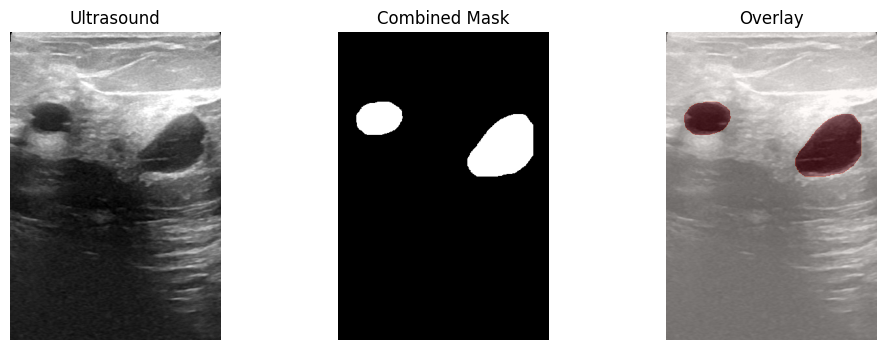

In [5]:
# --- Example on row 100 ---
sample =  df[df["image_path"].str.contains("100")].head(1).iloc[0]
img = cv2.imread(sample["image_path"], cv2.IMREAD_GRAYSCALE)

combined_mask = combine_masks(sample["mask_paths"], img.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Ultrasound")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(combined_mask, cmap="gray")
plt.title("Combined Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img, cmap="gray")
plt.imshow(combined_mask, cmap="Reds", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.show()

In [6]:
# Apply to dataframe (store combined mask as array)
df["combined_mask"] = df.apply(
    lambda row: combine_masks(row["mask_paths"], cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE).shape),
    axis=1
)

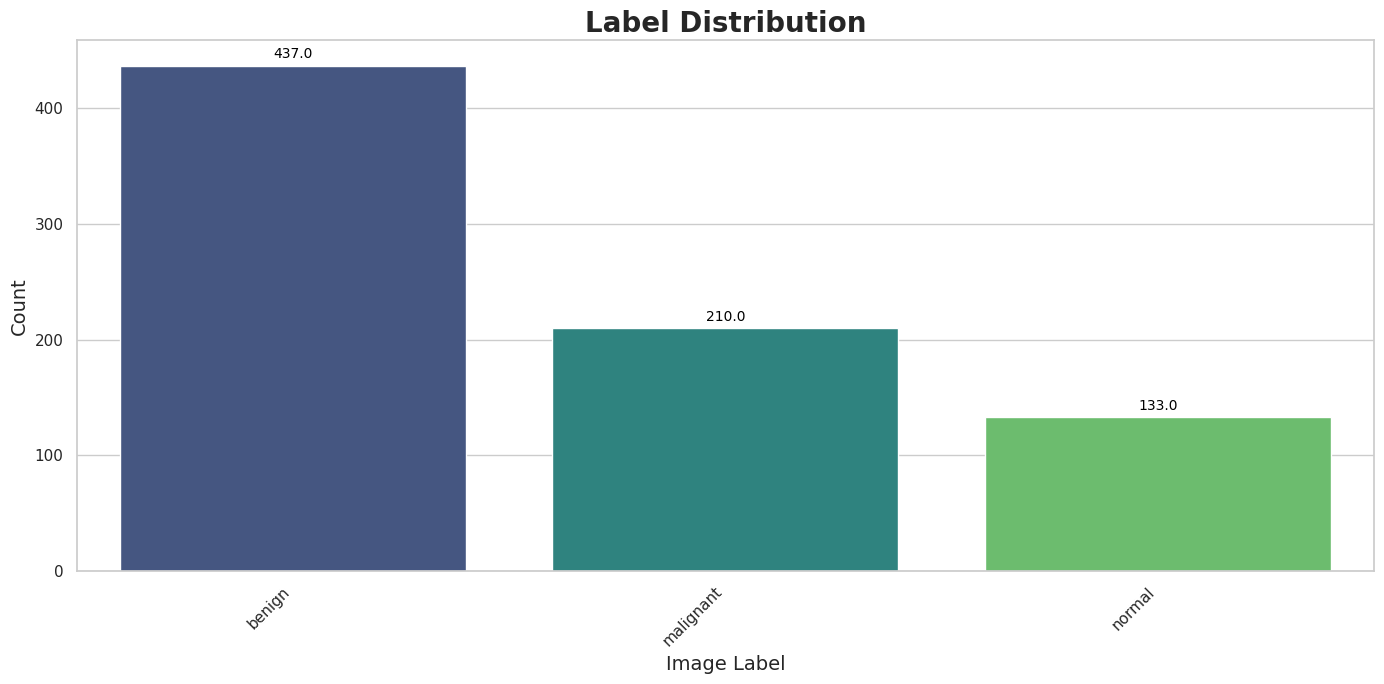

In [7]:
# Set style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(14, 7))

# Plot count of Image_Label column
ax = sns.countplot(data=df, x='label', palette='viridis', order=df['label'].value_counts().index)

# Set labels and title
plt.title("Label Distribution", fontsize=20, fontweight='bold')
plt.xlabel("Image Label", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Rotate x labels if needed
plt.xticks(rotation=45, ha='right')

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [8]:
df_normal = df[df['label']=='normal'].head(2)
df_benign = df[df['label']=='benign'].head(2)
df_malignant = df[df['label']=='malignant'].head(2)

> # ***Show samples before Preprocessing*** 

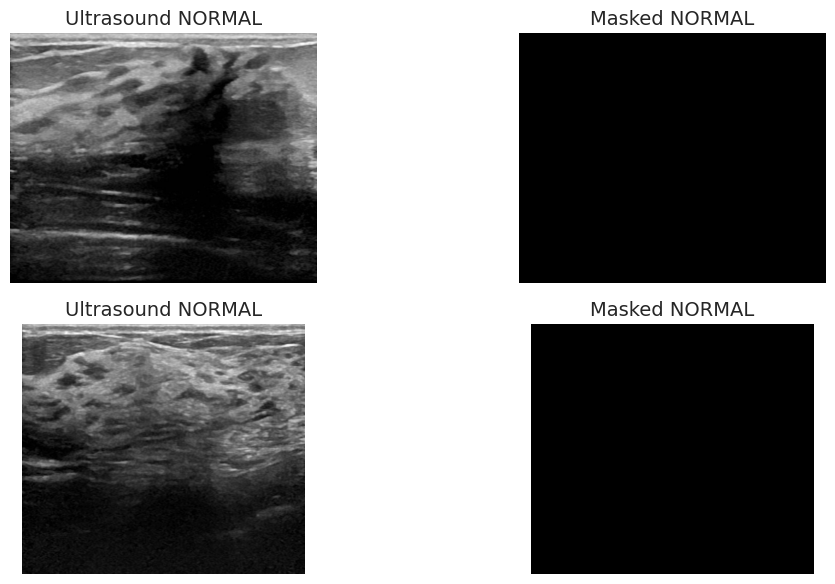

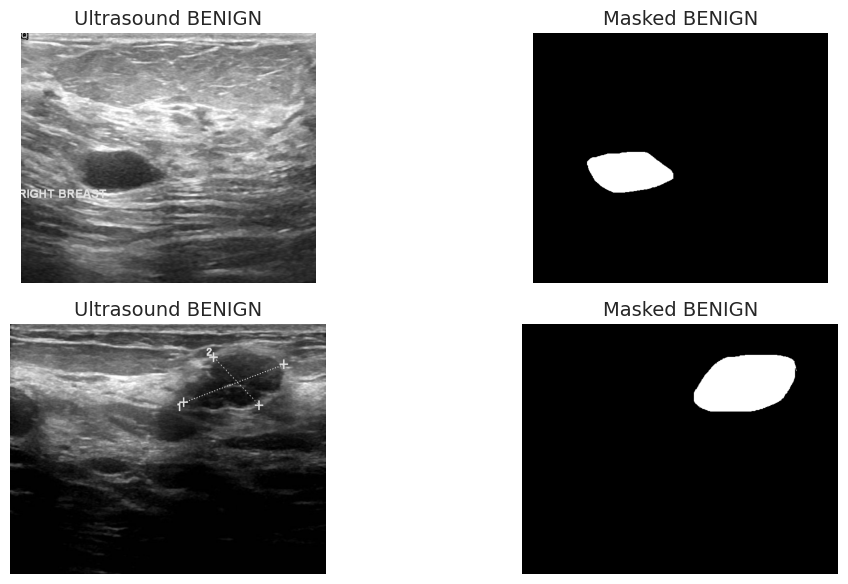

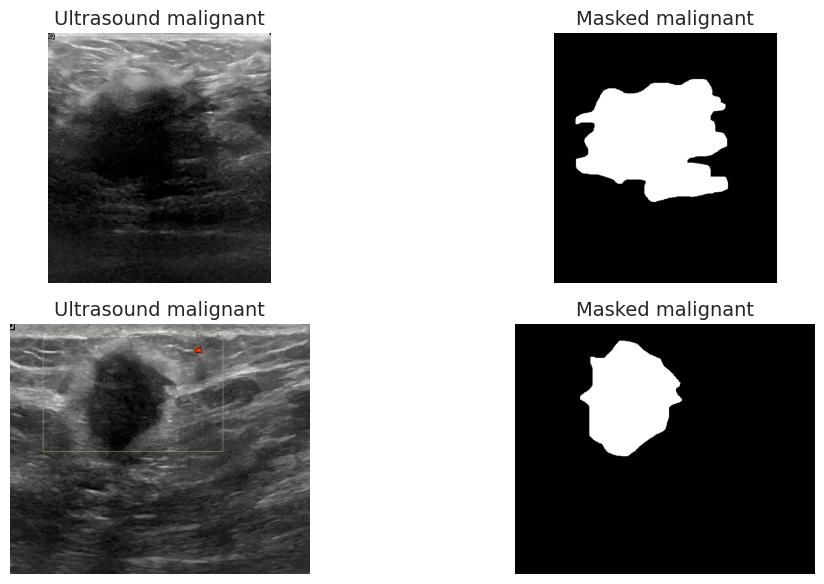

In [9]:
from PIL import Image

# class Normal
plt.figure(figsize=(12,6))
for i in range(2):
    # ultrasound
    img_path = df_normal.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path)                    # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_normal.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title("Ultrasound NORMAL", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked NORMAL", fontsize=14)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class benign
for i in range(2):
    # ultrasound
    img_path = df_benign.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path)                    # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_benign.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title("Ultrasound BENIGN", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked BENIGN", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class malignant
for i in range(2):
    # ultrasound
    img_path = df_malignant.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path)                   # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_malignant.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title("Ultrasound malignant", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked malignant", fontsize=14)
plt.tight_layout()
plt.show()

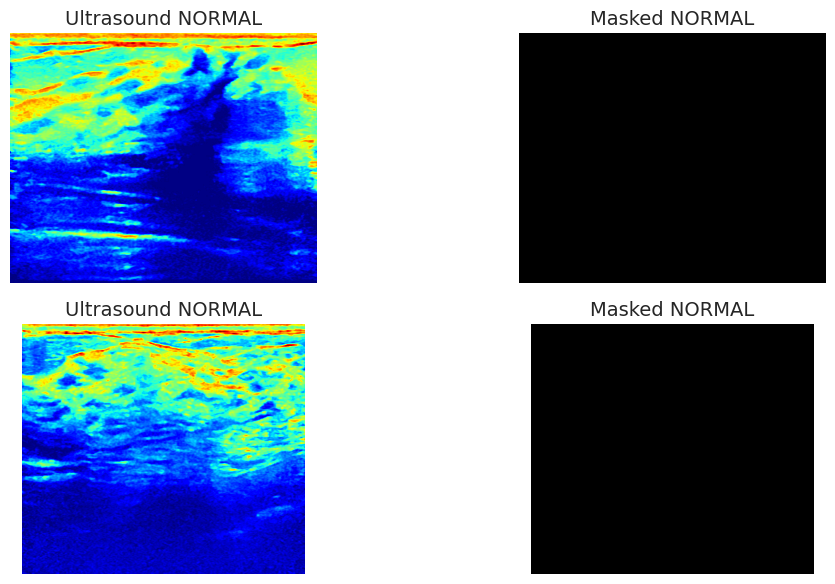

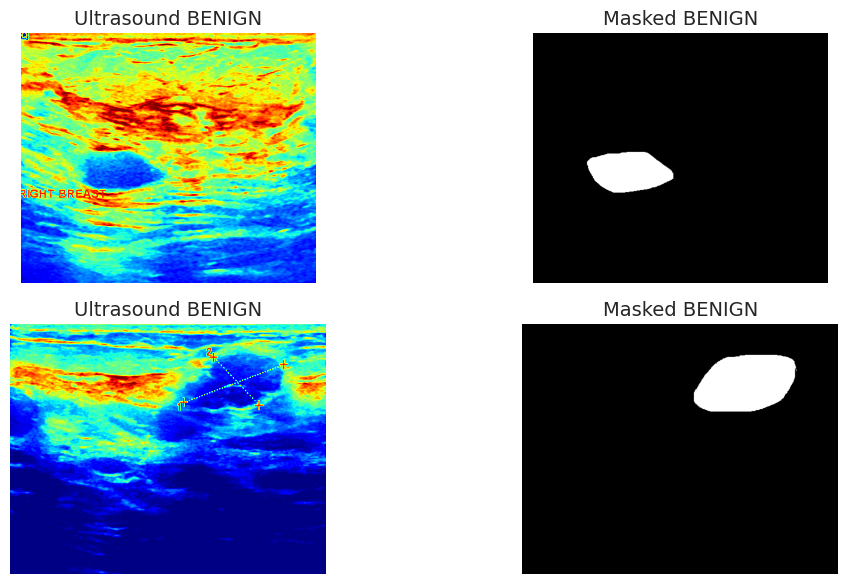

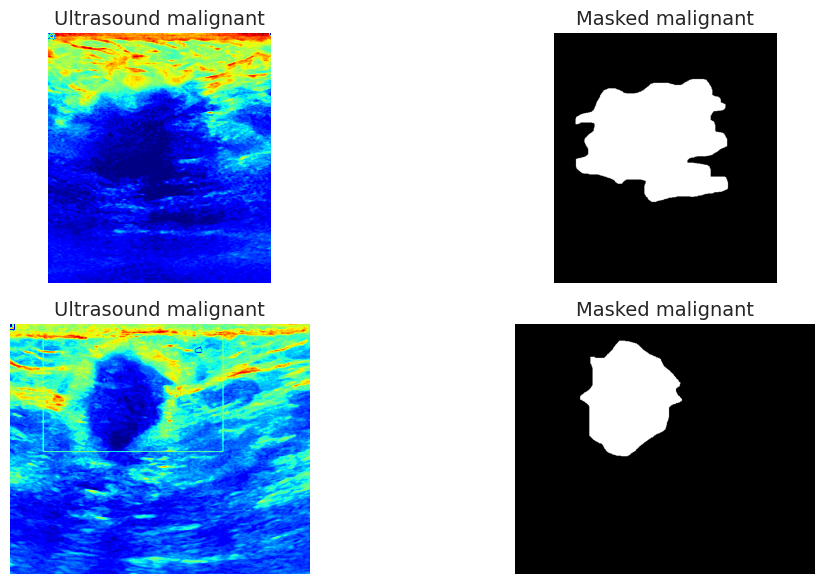

In [10]:
# class Normal
plt.figure(figsize=(12,6))
for i in range(2):
    # ultrasound
    img_path = df_normal.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale       # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_normal.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='jet')
    plt.axis('off')
    plt.title("Ultrasound NORMAL", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='jet')
        plt.axis('off')
        plt.title("Masked NORMAL", fontsize=14)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class benign
for i in range(2):
    # ultrasound
    img_path = df_benign.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale    # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_benign.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='jet')
    plt.axis('off')
    plt.title("Ultrasound BENIGN", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='jet')
        plt.axis('off')
        plt.title("Masked BENIGN", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class malignant
for i in range(2):
    # ultrasound
    img_path = df_malignant.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale      # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_malignant.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='jet')
    plt.axis('off')
    plt.title("Ultrasound malignant", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='jet')
        plt.axis('off')
        plt.title("Masked malignant", fontsize=14)
plt.tight_layout()
plt.show()

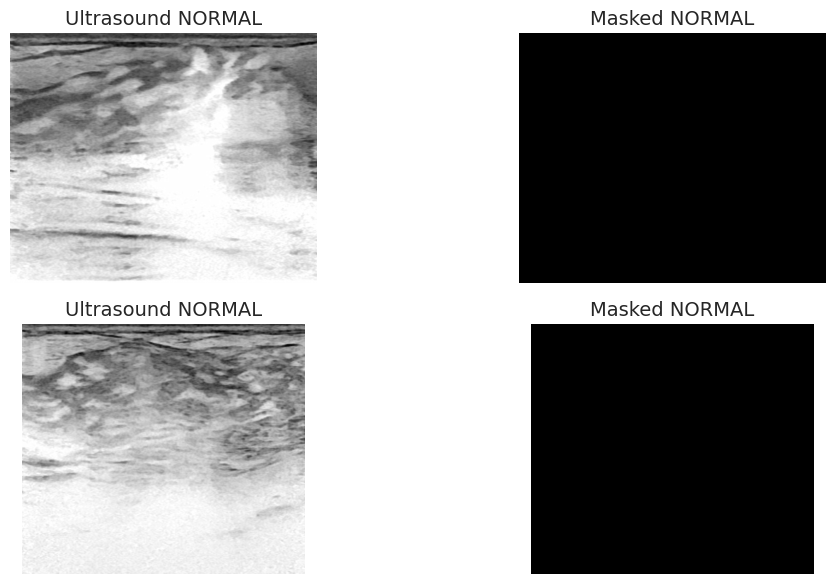

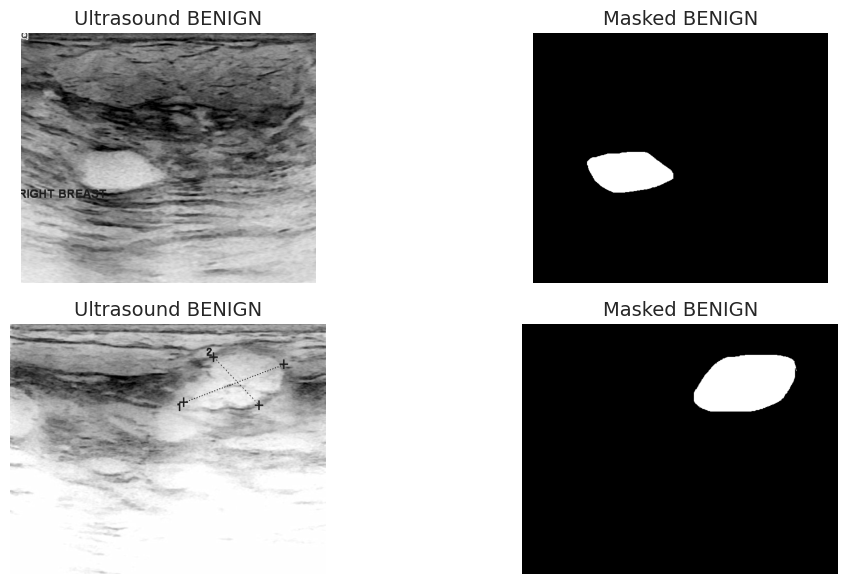

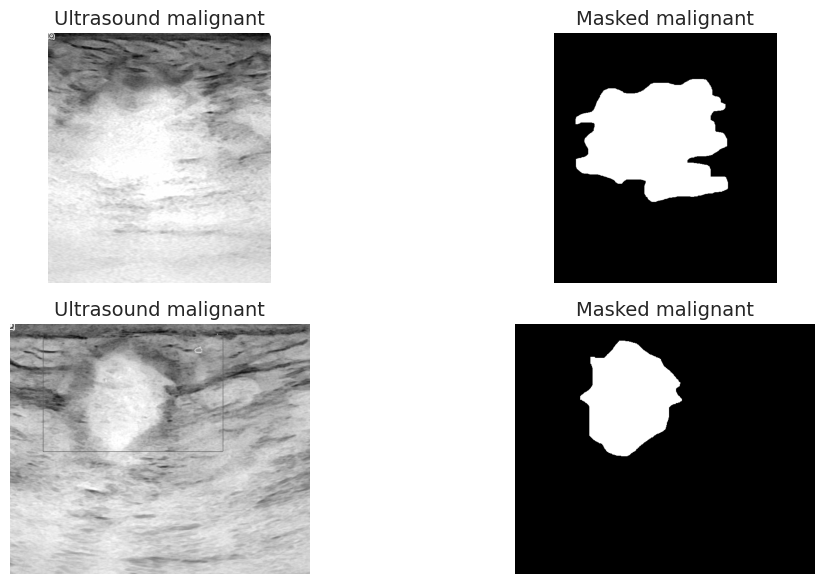

In [11]:
# class Normal
plt.figure(figsize=(12,6))
for i in range(2):
    # ultrasound
    img_path = df_normal.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale       # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_normal.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    plt.title("Ultrasound NORMAL", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked NORMAL", fontsize=14)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class benign
for i in range(2):
    # ultrasound
    img_path = df_benign.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale    # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_benign.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    plt.title("Ultrasound BENIGN", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked BENIGN", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
# class malignant
for i in range(2):
    # ultrasound
    img_path = df_malignant.iloc[i]['image_path']      # Get image path
    img      = Image.open(img_path).convert("L")   # grayscale      # Open image

    # Mask (list of mask paths, so we take the first one for display)
    mask_path = df_malignant.iloc[i]['mask_paths']
    if isinstance(mask_path,list) and len(mask_path)>0:
        mask      = Image.open(mask_path[0])
    else:
        mask= None
    # ultrasound
    plt.subplot(2,2, i*2 +1)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    plt.title("Ultrasound malignant", fontsize=14)

    if mask:
        plt.subplot(2,2, i*2 +2)
        plt.imshow(mask,cmap='gray')
        plt.axis('off')
        plt.title("Masked malignant", fontsize=14)
plt.tight_layout()
plt.show()

I0000 00:00:1758829743.158813      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758829743.159505      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


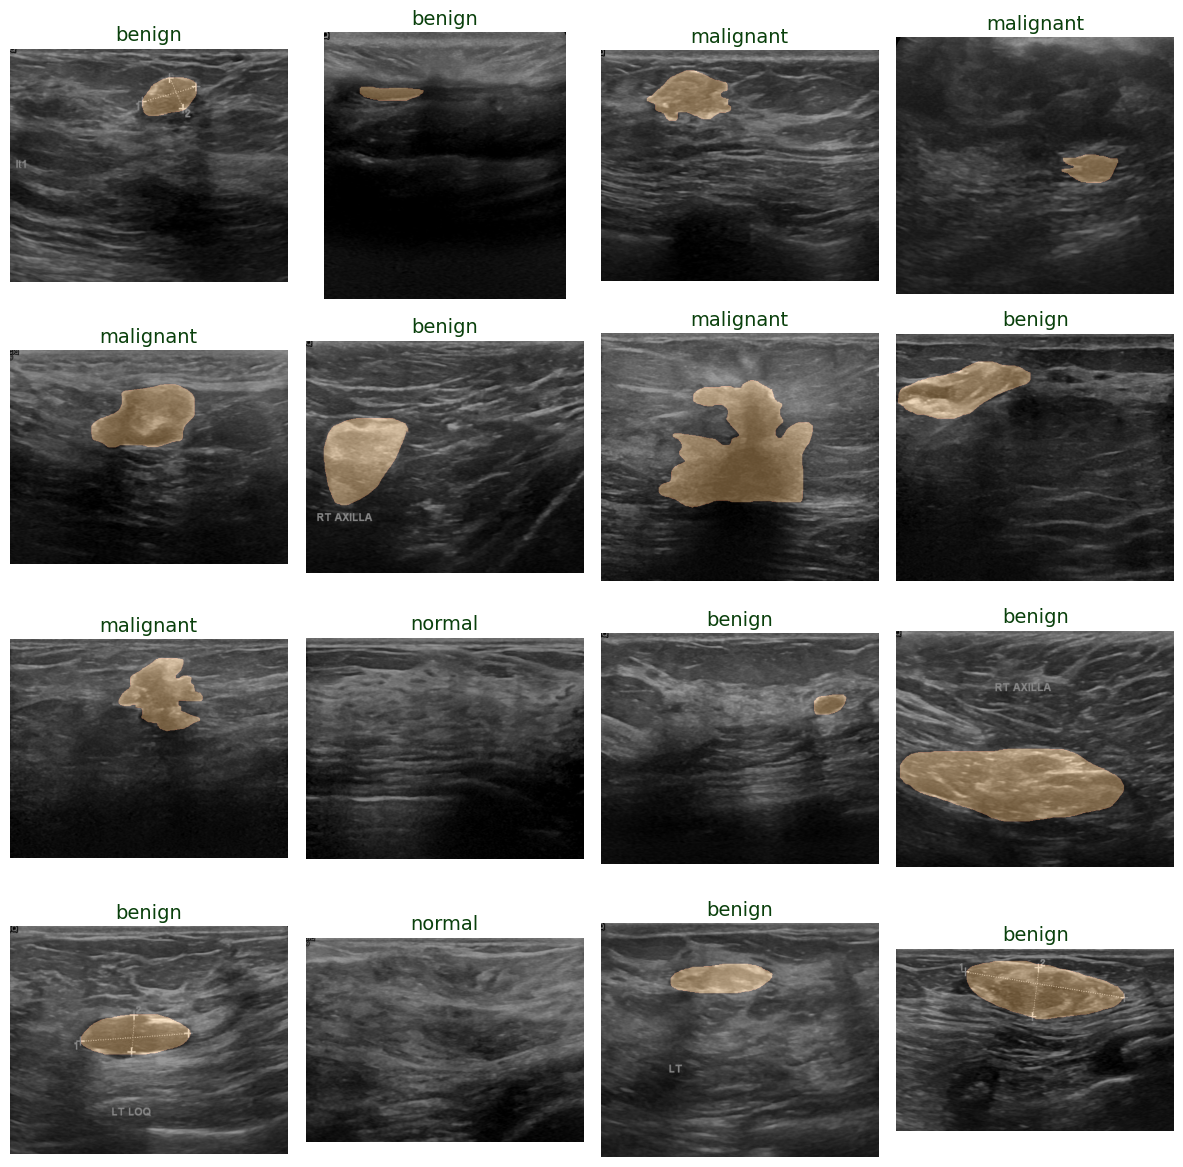

In [12]:
# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Plot first 16 samples
plt.figure(figsize=(12,12))
for i in range(16):
    img_path = df.iloc[i]['image_path']
    img = np.array(Image.open(img_path).convert("L"))   # Convert to numpy

    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.imshow(tf.squeeze(df.iloc[i]['combined_mask']),cmap='copper',alpha=0.4)
    
    label_name = df.iloc[i]['label']  # Already string
    plt.title(label_name, color='#0A400C', fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

> # ***Preprocessing*** 

> # ****Data Augmentation**** 

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size =160

image_datagen = ImageDataGenerator(
    #rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    #rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def preprocessing_and_augment(df, color_mode='grayscale', augment=False, augment_times=1):
    images = []
    masks  = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        img_path  = row['image_path']
        mask_arr  = row['combined_mask']  
        label     = row['label']

        # === Read Image ===
        if color_mode == 'grayscale':
            img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = mask_arr.copy()  
        else:
            img  = cv2.imread(img_path)
            img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = mask_arr.copy()

        img  = cv2.resize(img, (img_size, img_size))
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        # === CLAHE on image only ===
        if color_mode == 'grayscale':
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img   = clahe.apply(img)

        # === Denoising on image only ===
        img = cv2.fastNlMeansDenoising(img, None, h=10)

        # === Sharpening on image only ===
        blurred = cv2.GaussianBlur(img, (9, 9), 10.0)
        img     = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

        # === Normalize ===
        img  = img / 255.0
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)

        if color_mode == 'grayscale':
            img  = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)
        labels.append(label)

        # === Augmentation ===
        if augment:
            img_batch  = np.expand_dims(img, axis=0)
            mask_batch = np.expand_dims(mask, axis=0)

            img_aug_iter  = image_datagen.flow(img_batch, batch_size=1, seed=42)
            mask_aug_iter = mask_datagen.flow(mask_batch, batch_size=1, seed=42)

            for _ in range(augment_times):
                aug_img  = next(img_aug_iter)[0]
                aug_mask = next(mask_aug_iter)[0]
                aug_mask = (aug_mask > 0.5).astype(np.float32)
                images.append(aug_img)
                masks.append(aug_mask)
                labels.append(label)

    return np.array(images), np.array(masks), np.array(labels)

In [14]:
from sklearn.utils import shuffle
# Split 
df_normal    = df[df['label'] == 'normal']
df_benign    = df[df['label'] == 'benign']
df_malignant = df[df['label'] == 'malignant']

# Determine how many times to augment 
augment_times  = (len(df_benign) // len(df_normal)) - 1
augment_times2 = (len(df_benign) // len(df_malignant)) - 1

# Preprocess
image_normal_aug, mask_normal_aug,label_normal_aug           = preprocessing_and_augment(df_normal, color_mode='grayscale', augment=True, augment_times=augment_times)
image_benign , mask_benign  , label_benign                   = preprocessing_and_augment(df_benign,   color_mode='grayscale', augment=False)
image_malignant_aug, mask_malignant_aug, label_malignant_aug = preprocessing_and_augment(df_malignant, color_mode='grayscale', augment=True, augment_times=augment_times2)

# Combine both sets
images_combined = np.concatenate([image_normal_aug, image_benign, image_malignant_aug], axis=0)
masks_combined  = np.concatenate([mask_normal_aug, mask_benign, mask_malignant_aug], axis=0)
labels_combined = np.concatenate([label_normal_aug, label_benign, label_malignant_aug], axis=0)

# Shuffle images, masks, labels together
images_combined, masks_combined, labels_combined = shuffle(images_combined, masks_combined, labels_combined, random_state=42)

print(f"images_combined: {images_combined}\nmasks_combined: {masks_combined}\nlabels_combined:{labels_combined}")

Processing: 100%|██████████| 210/210 [00:09<00:00, 21.87it/s]


images_combined: [[[[0.16470588]
   [0.        ]
   [0.        ]
   ...
   [0.01568627]
   [0.01568627]
   [0.01568627]]

  [[0.15686275]
   [0.        ]
   [0.        ]
   ...
   [0.01568627]
   [0.01568627]
   [0.01568627]]

  [[0.10980392]
   [0.        ]
   [0.2745098 ]
   ...
   [0.01568627]
   [0.01568627]
   [0.01568627]]

  ...

  [[0.16470588]
   [0.16470588]
   [0.16078431]
   ...
   [0.08627451]
   [1.        ]
   [0.18039216]]

  [[0.17254902]
   [0.17254902]
   [0.16470588]
   ...
   [0.14901961]
   [0.        ]
   [0.02352941]]

  [[0.16470588]
   [0.16470588]
   [0.16078431]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.82890874]
   [0.84329796]
   [0.84329963]
   ...
   [0.53905487]
   [0.53905487]
   [0.53905487]]

  [[0.59060031]
   [0.56663358]
   [0.51551574]
   ...
   [0.45128536]
   [0.45128536]
   [0.45128536]]

  [[0.35413241]
   [0.32984427]
   [0.28916946]
   ...
   [0.49952593]
   [0.49952593]
   [0.49952593]]

  ...

  [[0.11605358]
   [0.

> # ***Show Samples after Preprocessing*** 

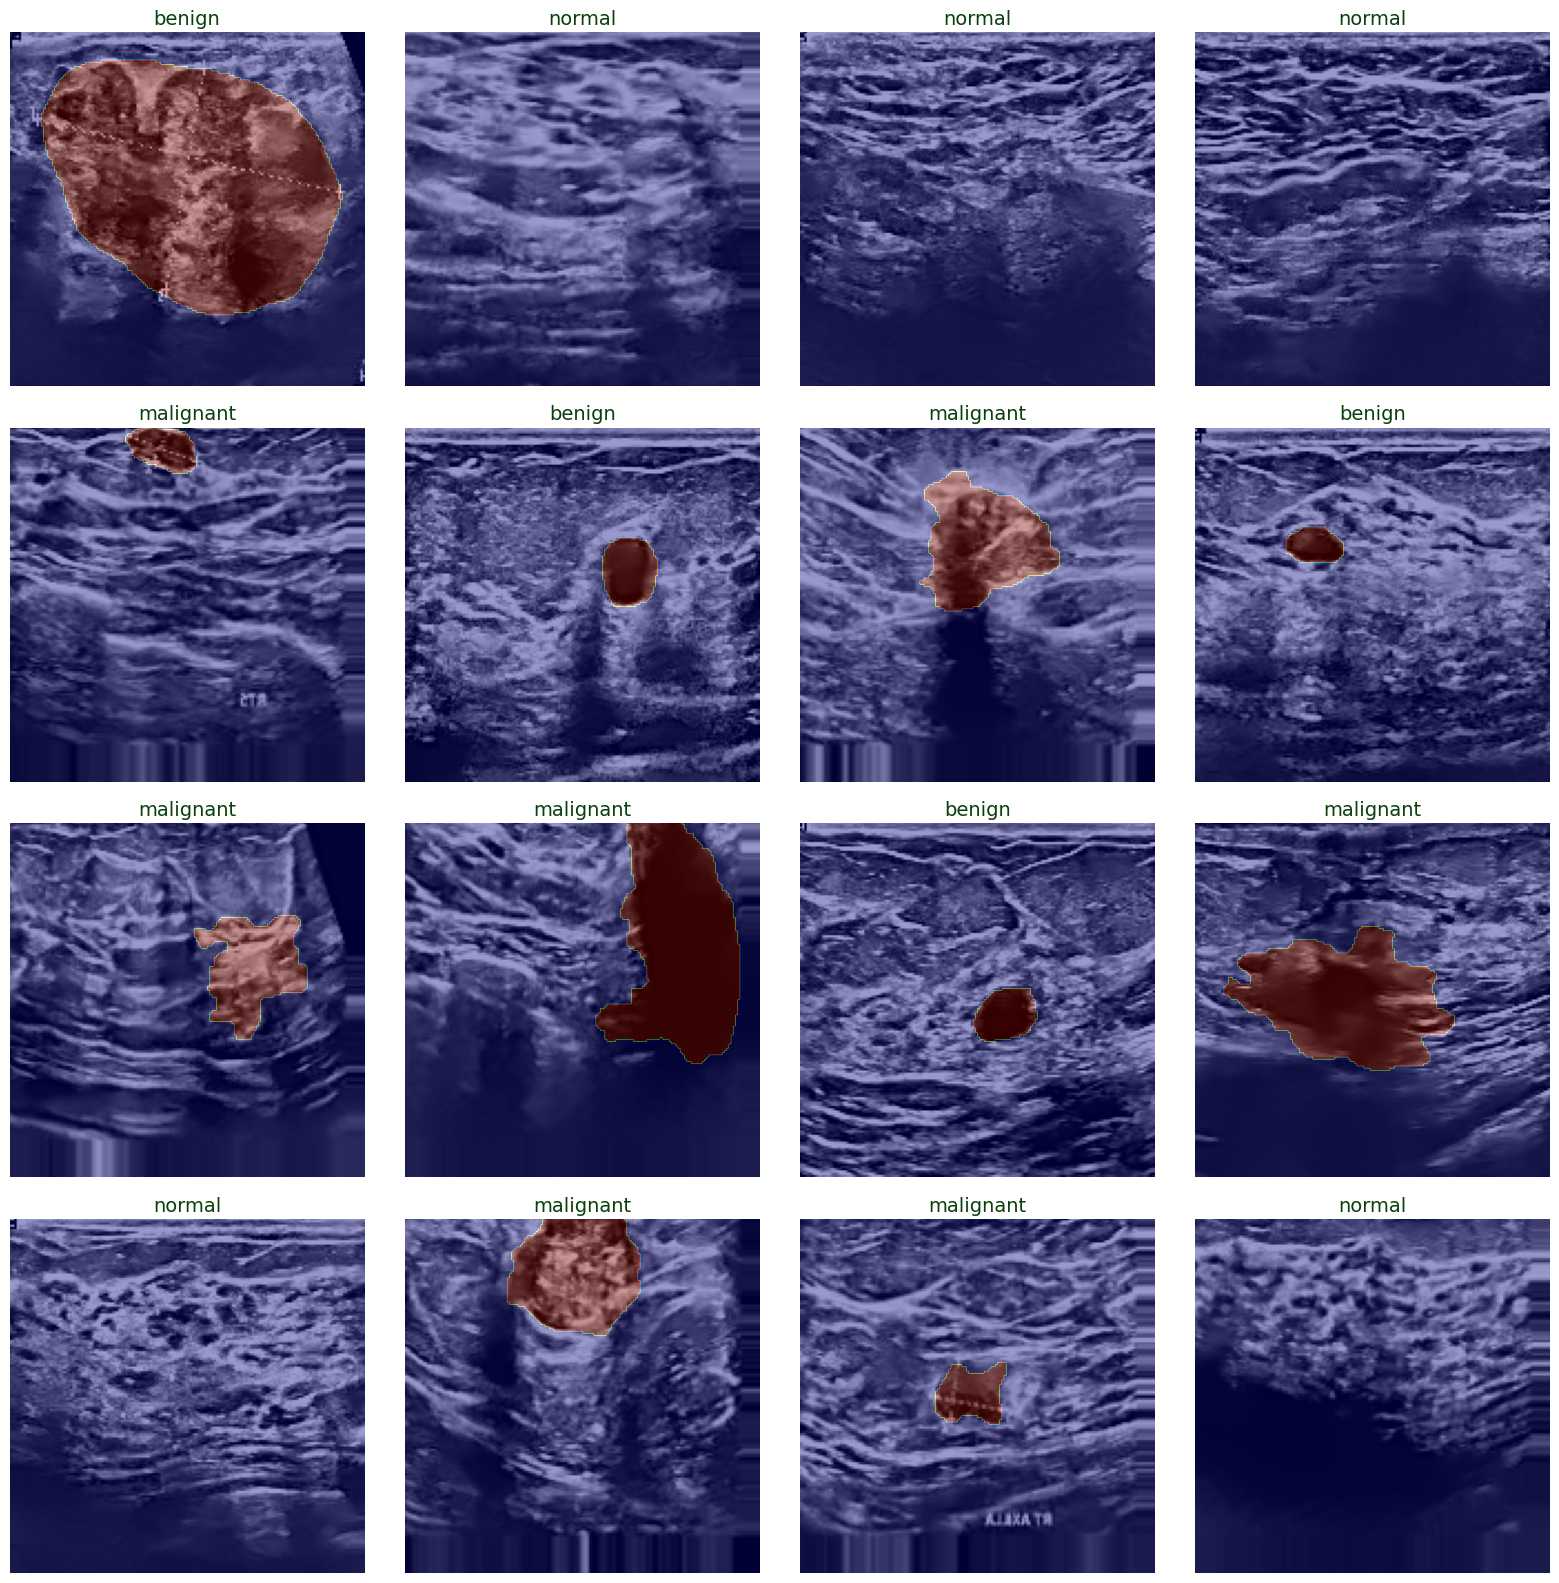

In [15]:
class_names = ['benign','normal','malignant']

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)

    img  = images_combined[i]
    mask = masks_combined[i]  

    # If grayscale, squeeze to 2D
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(np.squeeze(mask), cmap='jet', alpha=0.4)
    else:
        plt.imshow(img)
        plt.imshow(np.squeeze(mask), cmap='jet', alpha=0.4)

    label_name = labels_combined[i]
    plt.title(label_name, color='#0A400C', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

> # ***U_NET*** 

In [16]:
img_size    = (160, 160)
num_classes = 3
batch_size  = 32

def get_dataset(batch_size, img_size, input_imgs, target_masks, max_dataset_len=None):
    """Returns a TF Dataset from preloaded numpy arrays (images + masks)."""

    if max_dataset_len:
        input_imgs   = input_imgs[:max_dataset_len]
        target_masks = target_masks[:max_dataset_len]

    def gen():
        for img, mask in zip(input_imgs, target_masks):
            # Ensure image is float32
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            img = tf.image.resize(img, img_size)

            # Ensure mask is float32
            mask = tf.convert_to_tensor(mask, dtype=tf.float32)
            mask = tf.image.resize(mask, img_size, method="nearest")

            # Ensure mask has 3rd dimension
            if tf.rank(mask) == 2:
                mask = tf.expand_dims(mask, axis=-1)

            yield img, mask

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(img_size[0], img_size[1], input_imgs.shape[-1]), dtype=tf.float32),
            tf.TensorSpec(shape=(img_size[0], img_size[1], 1), dtype=tf.float32),
        )
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [17]:
# =========================
# Model Definition
# =========================
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=(160, 160, 1))

    # --- Encoder ---
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    # --- Decoder ---
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,403 (7.85 MB)

 Trainable params: 2,054,627 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

> # ***Set aside a validation split*** 

In [18]:
# =========================
# Train/Val Split (AFTER Augmentation)
# =========================
num_samples = len(images_combined)
val_samples = int(0.2 * num_samples)

train_images = images_combined[:-val_samples]
train_masks  = masks_combined[:-val_samples]
train_labels = labels_combined[:-val_samples]

val_images = images_combined[-val_samples:]
val_masks  = masks_combined[-val_samples:]
val_labels = labels_combined[-val_samples:]

print(f"Train samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

# =========================
# Create TF Datasets
# =========================
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_images,
    train_masks,
    max_dataset_len=len(train_images)
)

valid_dataset = get_dataset(
    batch_size,
    img_size,
    val_images,
    val_masks,
    max_dataset_len=len(val_images)
)

print("✅ Train dataset ready:", train_dataset)
print("✅ Validation dataset ready:", valid_dataset)

Train samples: 1005
Validation samples: 251
✅ Train dataset ready: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None))>
✅ Validation dataset ready: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None))>


> #  ***Train the model*** 

In [19]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20


I0000 00:00:1758829807.387298      63 service.cc:148] XLA service 0x7f0ecc03bca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758829807.388275      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758829807.388300      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1758829808.442433      63 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1758829809.208805      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 38s 38s/step - accuracy: 0.4295 - loss: 2.5046

I0000 00:00:1758829826.930656      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     31/Unknown 44s 175ms/step - accuracy: 0.8220 - loss: 0.8383

W0000 00:00:1758829833.113851      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     32/Unknown 57s 592ms/step - accuracy: 0.8241 - loss: 0.8275

W0000 00:00:1758829848.048169      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1758829849.937724      63 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 865ms/step - accuracy: 0.8262 - loss: 0.8173 - val_accuracy: 0.9211 - val_loss: 0.3129
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9285 - loss: 0.2228 - val_accuracy: 0.9211 - val_loss: 0.3068
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9368 - loss: 0.1836 - val_accuracy: 0.9211 - val_loss: 0.3346
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9426 - loss: 0.1614 - val_accuracy: 0.9211 - val_loss: 0.3390
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9479 - loss: 0.1443 - val_accuracy: 0.9211 - val_loss: 0.3197
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9529 - loss: 0.1294 - val_accuracy: 0.9211 - val_loss: 0.2939
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.9582 - loss: 0.1146 - val_accuracy: 0.9211 - val_loss: 0.2687
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.9639 - loss: 0.0996 - val_accuracy: 0.9211 - val

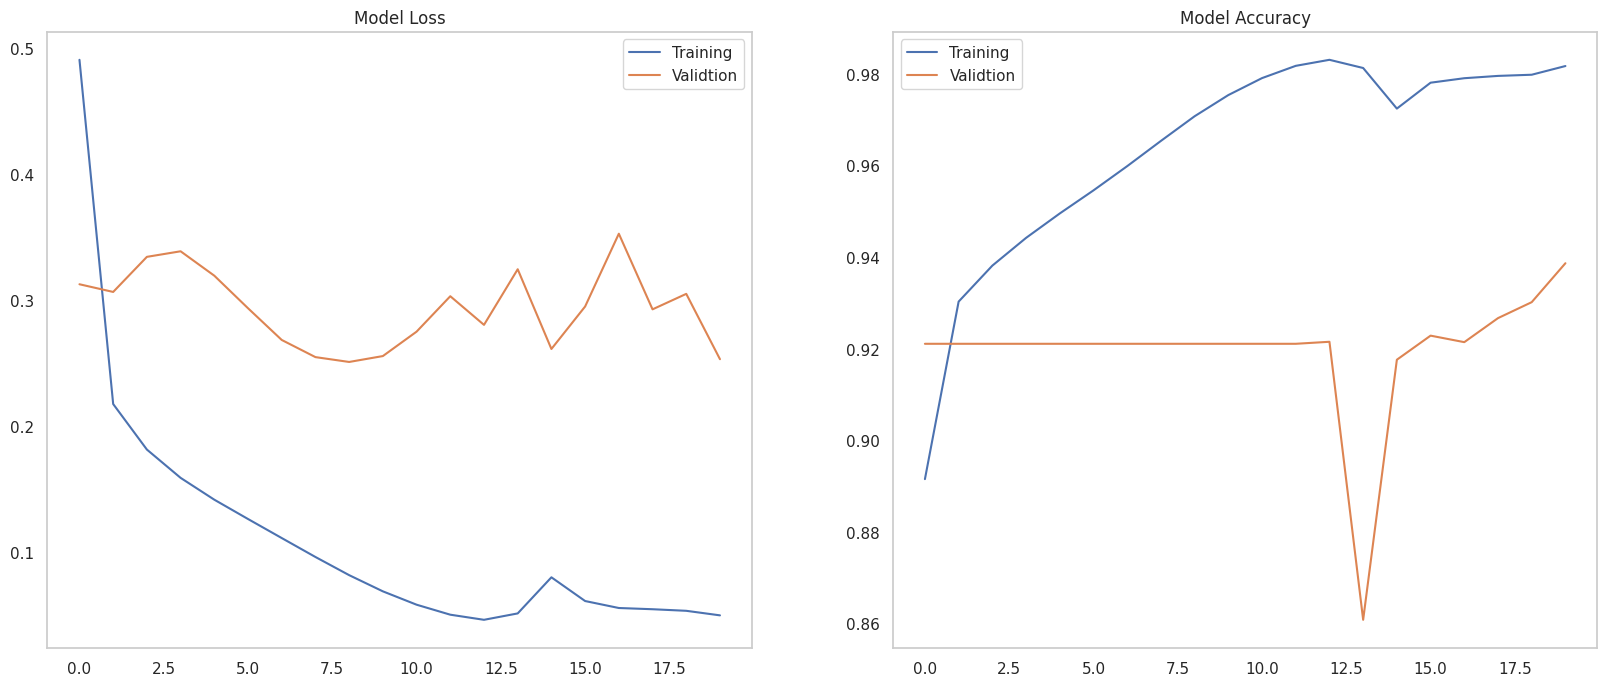

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

iou = history.history.get('iou', [0]*len(loss))
val_iou = history.history.get('val_iou', [0]*len(loss))

plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step


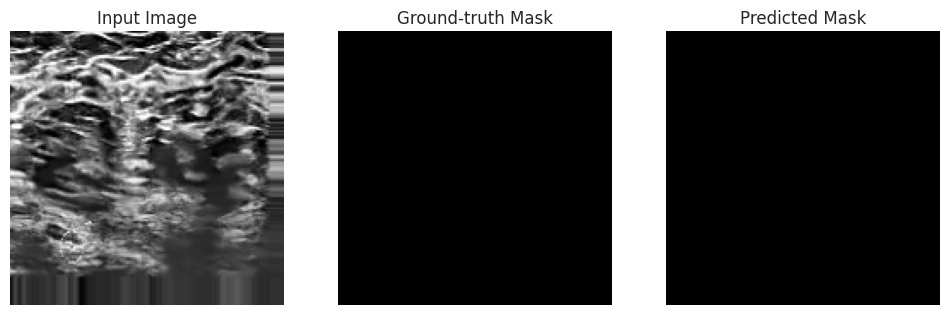

In [21]:
from PIL import Image, ImageOps

i = 10  # index of the sample you want to visualize

# Get one sample from validation set
img = val_images[i]        # (H, W, C)
mask_array = val_masks[i]  # (H, W, 1)

plt.figure(figsize=(12, 4))

# Input image
plt.subplot(1, 3, 1)
plt.title("Input Image")
if img.shape[-1] == 1:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    plt.imshow(img)
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.title("Ground-truth Mask")
plt.imshow(mask_array.squeeze(), cmap='gray')
plt.axis('off')

# Model prediction (whole validation set)
val_preds_array = model.predict(valid_dataset)

# Get predicted mask for this index
# Take argmax across classes if it's multi-class segmentation
pred_mask = np.argmax(val_preds_array[i], axis=-1)

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')  # 'jet' to show different classes in color
plt.axis('off')

plt.show()


In [22]:
results = model.evaluate(valid_dataset)
print("Loss:", results[0])
print("Pixel Accuracy:", results[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9337 - loss: 0.2681
Loss: 0.2534574866294861
Pixel Accuracy: 0.9387473464012146


In [23]:
results = model.evaluate(train_dataset)
print("Loss:", results[0])
print("Pixel Accuracy:", results[1])

     31/Unknown 4s 113ms/step - accuracy: 0.9514 - loss: 0.1991

W0000 00:00:1758829998.084821      64 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9513 - loss: 0.1996
Loss: 0.2072385996580124
Pixel Accuracy: 0.9498633742332458


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


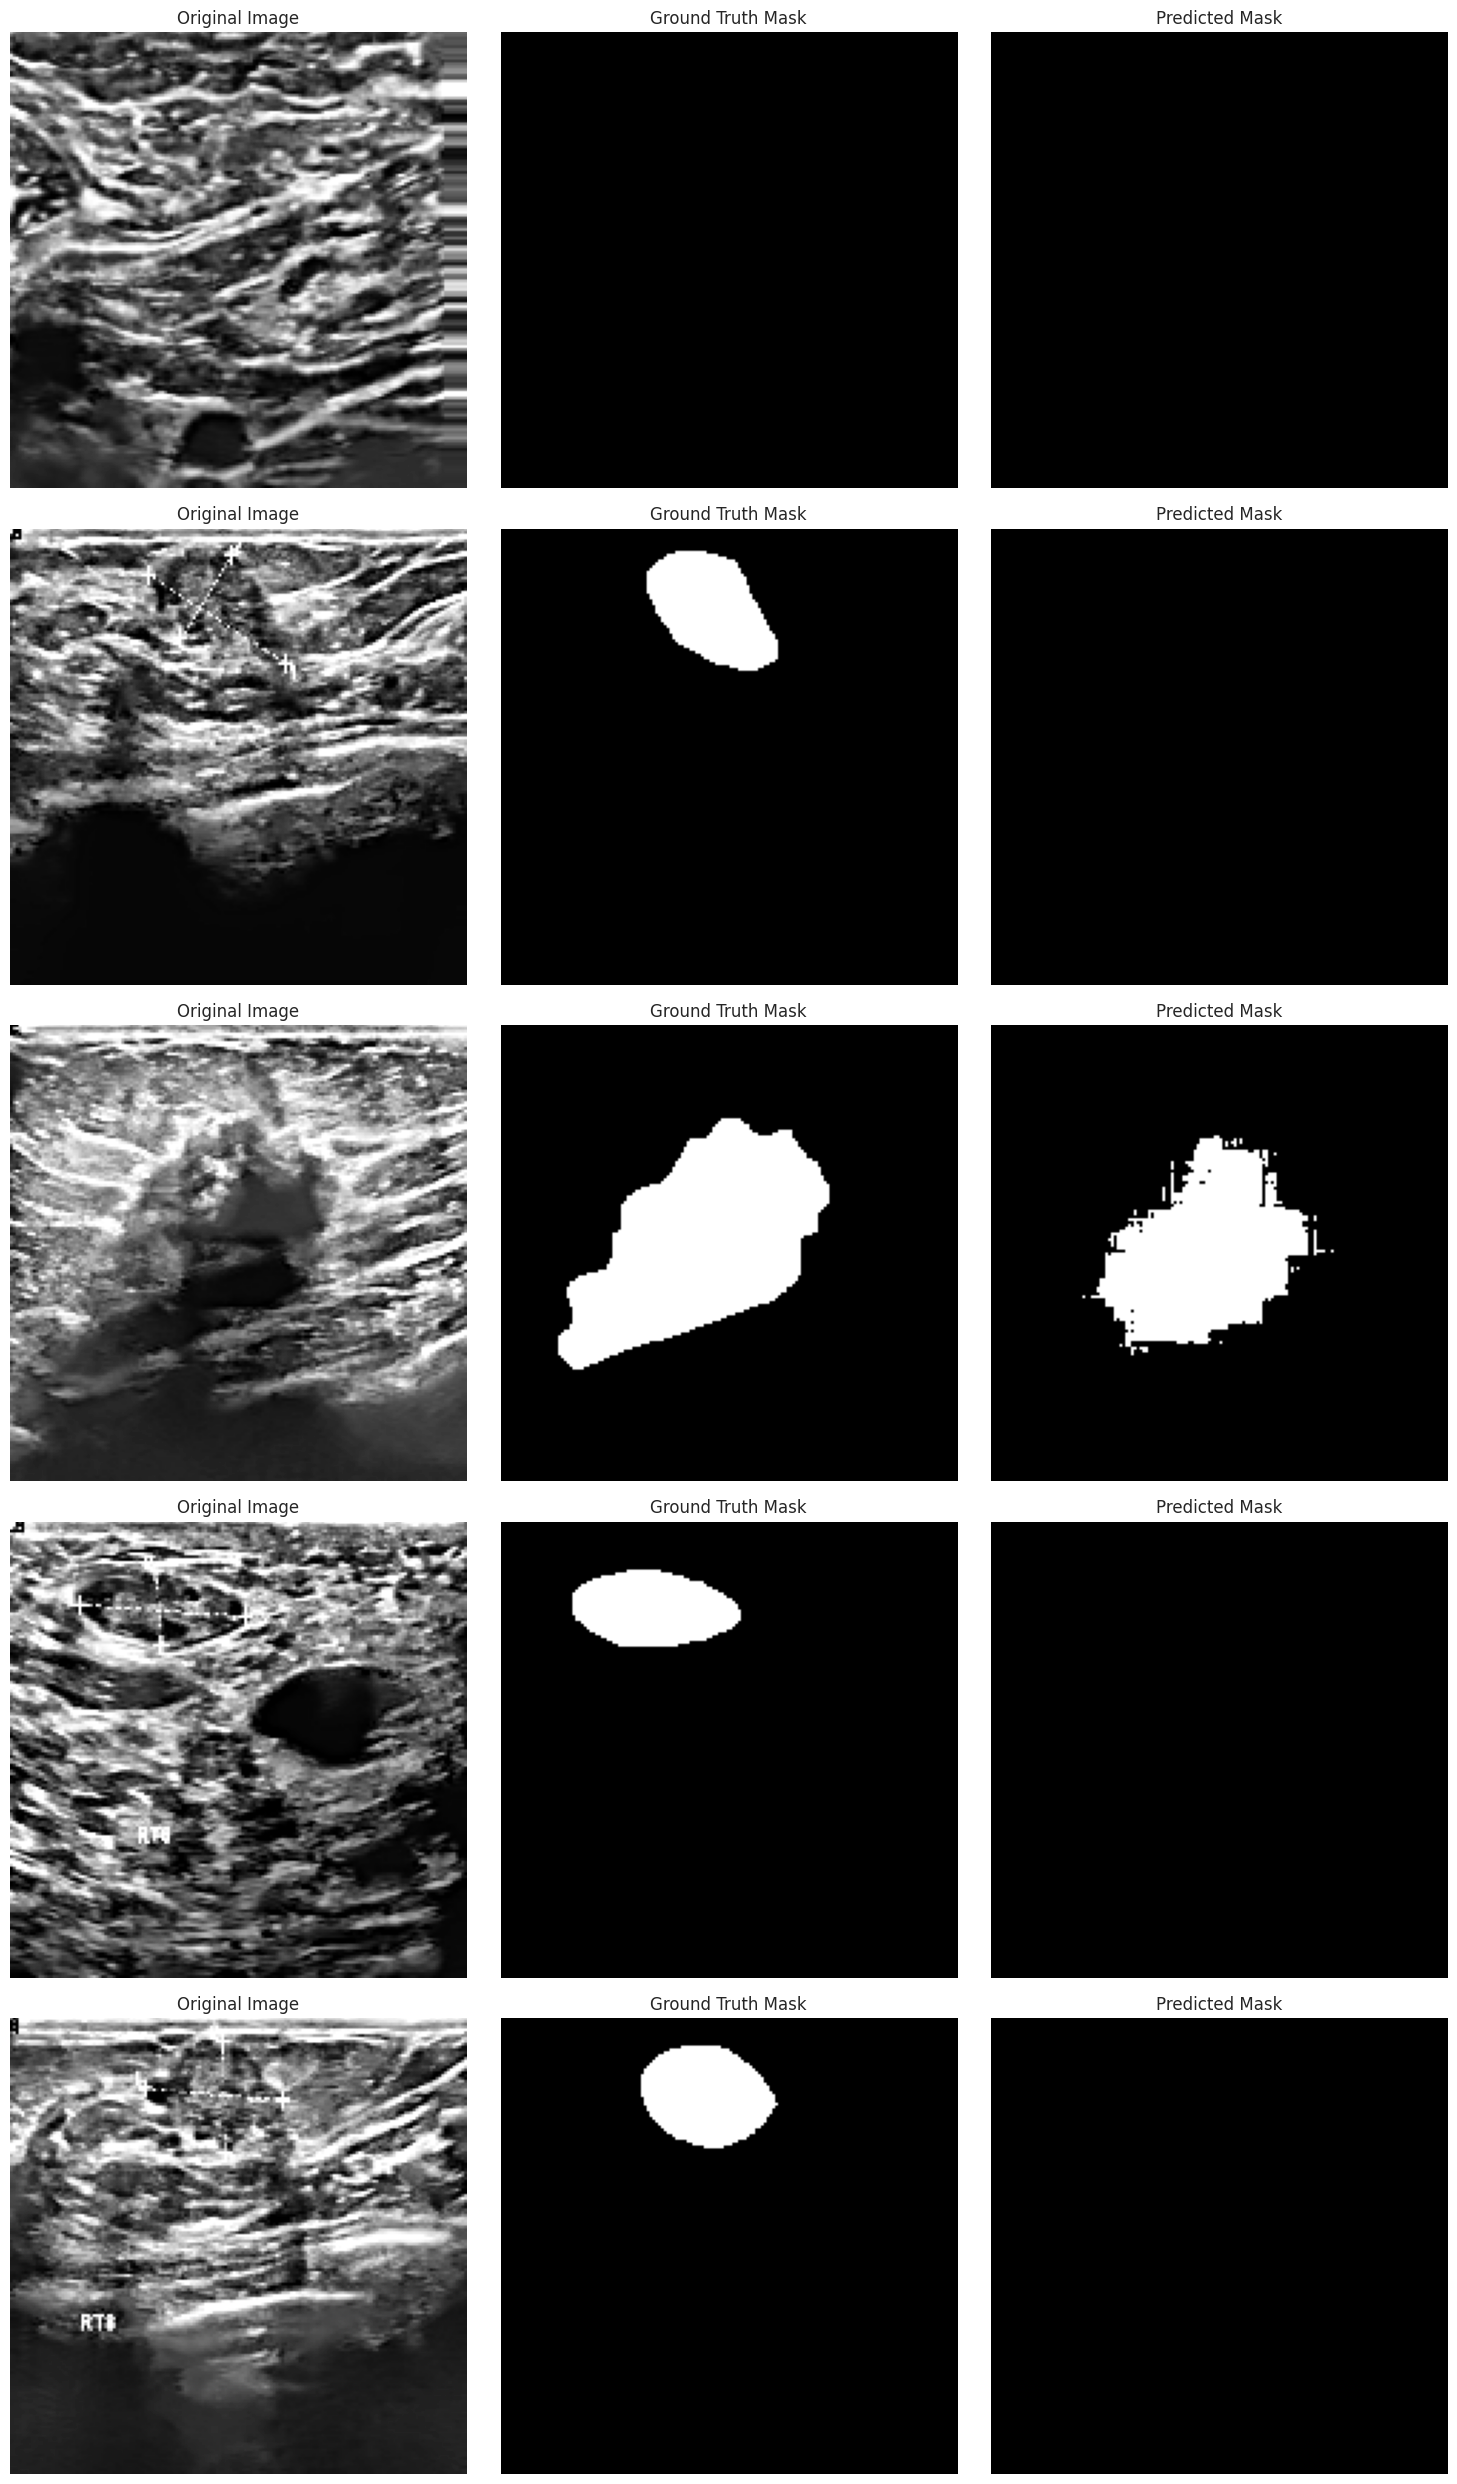

In [24]:
num_display = 5
ids = np.random.randint(0, len(val_images), size=num_display)

plt.figure(figsize=(15, num_display * 5))

for idx, i in enumerate(ids):
    # === Load and preprocess image ===
    img = val_images[i]

    # === Load mask ===
    mask = val_masks[i]
    # === Predict ===
    pred = model.predict(img[np.newaxis, ...])
    if pred.shape[-1] > 1:  # Multi-class segmentation
        pred_mask = np.argmax(pred[0], axis=-1)
    else:  # Binary segmentation
        pred_mask = (pred[0, ..., 0] > 0.5).astype(np.uint8)

    # === Plot ===
    plt.subplot(num_display, 3, idx * 3 + 1)
    plt.imshow(img,cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_display, 3, idx * 3 + 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(num_display, 3, idx * 3 + 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()